<a href="https://colab.research.google.com/github/Giuliafranchi1/Algorithm_massivedata/blob/master/RIDOTTO_FRANCHI_PROJECT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as t
from torch import nn
import os
import random
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
from tqdm import tqdm

#reproducibility
seed=1
np.random.seed(seed)
random.seed(seed)
t.manual_seed(seed)
# for cuda
t.cuda.manual_seed_all(seed)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
t.backends.cudnn.enabled = False
os.environ['PYTHONHASHSEED'] = str(seed)

#set GPU
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
#Import dataset from Kaggle

!mkdir -p /root/.kaggle
!echo '{"username":"giuliafranchi","key":"4cfe8adf4b6fb74cc4f72ff3a92f971f"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

100% 6.56G/6.56G [05:43<00:00, 18.2MB/s]
100% 6.56G/6.56G [05:43<00:00, 20.5MB/s]


In [ ]:
!unzip plant-leaves-for-image-classification.zip

## Pre-processing

In [ ]:
#access to the folder of imgs and labels
img_names = np.array(list(glob('./Plants_2/*/*/*')))
np.random.shuffle(img_names)

loaded_imgs = [] #images
loaded_labels = [] #names of plants species
loaded_modes = [] #train/valid/test
print(f"{len(img_names)=}") #4494
for i in tqdm(range(300)):
  img_name = img_names[i]
  img = np.array(
      Image.open(img_name).convert('L') #grey scale from PIL library
  )
  resize_factor = 30
  new_shape = (np.array(img.shape) / resize_factor).astype(int)
  img_resized = resize(img, new_shape)
  img_cropped = img_resized[
      400// resize_factor:-400//resize_factor, #width 200-2*13.34 x-axis
      400//resize_factor:-400//resize_factor #height 133-2*13.34 y-axis
  ]
  img = img_cropped
  img = t.from_numpy(img) #convert img into tensor
  label = img_name.split('/')[-2].split(' ')[0] #plant name
  mode = img_name.split('/')[2] #train/valid/test
  loaded_imgs.append(img)
  loaded_labels.append(label)
  #if mode != 'train':
    #print(mode)
  loaded_modes.append(mode)

len(img_names)=4494


100%|██████████| 300/300 [20:28<00:00,  4.10s/it]


In [ ]:
#divide each label and trasform from string into integer number 
unique_labels = list(set(loaded_labels))
numerical_labels = []
for label in loaded_labels:
    numerical_labels.append(
        unique_labels.index(label)
    )
numerical_labels = t.tensor(numerical_labels) #convert into tensor


# separate in train/test/valid/images to predict
unique_modes = list(set(loaded_modes))

print(f"Train: {len([l for l in loaded_modes if l == 'train'])}") #4274
print(f"Test: {len([l for l in loaded_modes if l == 'test'])}") #110
print(f"Valid: {len([l for l in loaded_modes if l == 'valid'])}") #110


dataloaders = {}
for mode in unique_modes:
  mask = np.array([m == mode for m in loaded_modes]) # [True, False, ...]
  labels = numerical_labels[mask]
  imgs = t.stack([loaded_imgs[i] for i in range(len(mask)) if mask[i]])
  # create dataset
  dataset = t.utils.data.TensorDataset(imgs, labels)
  # create dataloader + specify batch size + shuffle=True 
  dataloader = t.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
  dataloaders[mode] = dataloader

print(dataloaders)

Train: 279
Test: 12
Valid: 9
{'test': <torch.utils.data.dataloader.DataLoader object at 0x7f915b2fc610>, 'train': <torch.utils.data.dataloader.DataLoader object at 0x7f915b2fc5b0>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7f915b2fc250>}


In [ ]:
train_dataloader = dataloaders['train']

for batch_imgs, batch_labels in train_dataloader:
 print(batch_imgs.shape) # shape = [64, 106, 173]
 print(batch_labels.shape) # shape = [64]
 break

torch.Size([64, 106, 173])
torch.Size([64])


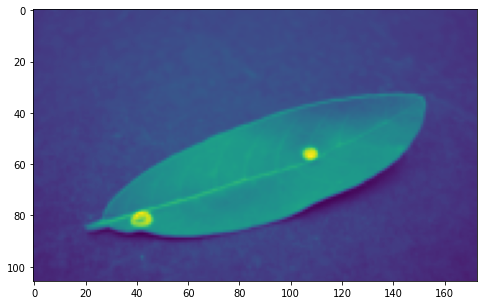

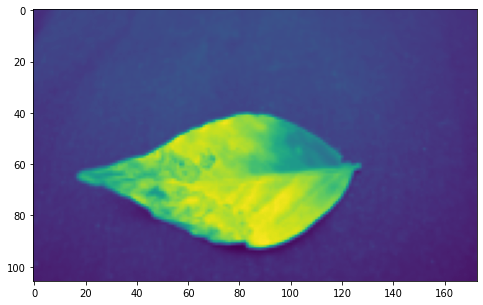

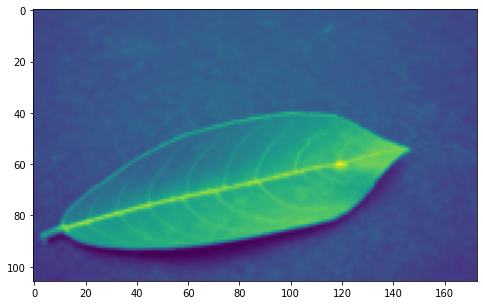

In [ ]:
#show one img for each mode: train, test, valid
plt.rcParams['figure.figsize'] = [10, 5]
for imgs, labels in dataloaders['train']:
  plt.imshow(imgs[0])
  plt.show()
  break

for imgs, labels in dataloaders['test']:
  plt.imshow(imgs[0])
  plt.show()
  break

for imgs, labels in dataloaders['valid']:
  plt.imshow(imgs[0])
  plt.show()
  break

## Model for my neural network

In [ ]:
try:
  from torchsummary import summary
except:
  !pip install torch-summary
  from torchsummary import summary

#general structure of my model
def conv_block(in_c, out_c, k=3, pad=1):
    return nn.Sequential(
        nn.BatchNorm2d(in_c),
        nn.Conv2d(
            in_c,
            out_c,
            k,
            padding=pad,
            bias=False 
        ), 
        nn.MaxPool2d(2), 
        nn.ReLU()
    )

def get_model(first_layer_kernel_size, dropout_rate):
  return nn.Sequential(
        conv_block(1, 16, first_layer_kernel_size), 
        conv_block(16, 32),
        conv_block(32, 64),
        conv_block(64, 128),
        conv_block(128, 256),
        nn.Flatten(),  
        nn.Linear(3840, 256),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(256, 12),
        nn.Softmax(1)
  ).to(device) 


## Hyperparemeter Tuning & Model Selection

In [ ]:
def train_single_epoch(*, optim, loss_fn, model):
  tot_loss = 0
  n_imgs = 0
  for img, label in tqdm(dataloaders['train']):
    label = label.to(device)
    batch_size = img.shape[0]
    img = img.to(device)
    optim.zero_grad()
    img = (img[:, None] / 255).float() #normalization of imgs-> pixels 0-255
    pred_label = model(img)
    loss = loss_fn(pred_label, label) 
    loss.backward()
    optim.step() 
    tot_loss += loss.item()
    n_imgs += batch_size
  return (tot_loss / n_imgs)

  
def test_or_valid(*, dataloader, model):
  loss_fn = t.nn.CrossEntropyLoss()
  with t.no_grad():
    tot_loss = 0
    n_imgs = 0
    correct_preds = 0 
    for batch_imgs, batch_labels in tqdm(dataloader):
      batch_labels = batch_labels.to(device)
      batch_imgs = batch_imgs.to(device)
      batch_size = batch_imgs.shape[0]
      batch_imgs = (
          batch_imgs[:, None]/ 255 #normalization of imgs-> pixels 0-255
      ).float()
      pred_batch_labels = model(batch_imgs)
      pred_batch_class = t.argmax(pred_batch_labels, dim=1)
      correct_preds += (pred_batch_class == batch_labels).sum().item()
      loss = loss_fn(pred_batch_labels, batch_labels)
      tot_loss += loss.item()
      n_imgs += batch_size

    mean_loss = tot_loss / n_imgs
    accuracy = correct_preds / n_imgs

  return mean_loss, accuracy

def train(*, lr, n_epochs, first_layer_kernel_size, dropout_rate, plot=False): 
  model = get_model(first_layer_kernel_size, dropout_rate )
  if plot:
    summary(model, (1, 106, 173))
  optim = t.optim.Adam(model.parameters(), lr=lr)
  loss_fn = t.nn.CrossEntropyLoss()
  train_losses = []
  val_losses = []
  val_accs = []
  for epoch in range(n_epochs):
      train_loss = train_single_epoch(
        model=model,
        loss_fn=loss_fn,
        optim=optim
      )
      val_loss, val_acc = test_or_valid(
        dataloader=dataloaders['valid'],
        model=model,
      ) #testing
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      if plot:
        print(
          f"\nEpoch: {epoch}, train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
        )


  if plot:
    #plotting
    fig, axes = plt.subplots(2, 1)
    axes[0].plot(t.arange(n_epochs), train_losses, label='train_loss')
    axes[0].plot(t.arange(n_epochs), val_losses, label='val_loss')
    axes[0].legend()
    axes[1].plot(t.arange(n_epochs), val_accs, label='val_accuracy')
    axes[1].legend()
    plt.show()
  return val_acc, model


In [ ]:
try:
  import optuna
except:
  !pip install optuna
  import optuna

def objective(trial):
    first_layer_kernel_size = trial.suggest_int('first_layer_kernel_size', 1, 5)
    lr = trial.suggest_float('lr', 0.0001, 0.001)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    val_acc, _ = train(
      lr=lr,
      first_layer_kernel_size=first_layer_kernel_size,
      dropout_rate=dropout_rate,
      n_epochs=1
    )
    return val_acc 

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed)) 
study.optimize(
    objective,
    n_trials=20
)


In [ ]:
study.best_params

{'first_layer_kernel_size': 1,
 'lr': 0.00041100465433874294,
 'dropout_rate': 0.258706989692268}

## Training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 106, 173]               2
            Conv2d-2         [-1, 16, 108, 175]              16
         MaxPool2d-3           [-1, 16, 54, 87]               0
              ReLU-4           [-1, 16, 54, 87]               0
       BatchNorm2d-5           [-1, 16, 54, 87]              32
            Conv2d-6           [-1, 32, 54, 87]           4,608
         MaxPool2d-7           [-1, 32, 27, 43]               0
              ReLU-8           [-1, 32, 27, 43]               0
       BatchNorm2d-9           [-1, 32, 27, 43]              64
           Conv2d-10           [-1, 64, 27, 43]          18,432
        MaxPool2d-11           [-1, 64, 13, 21]               0
             ReLU-12           [-1, 64, 13, 21]               0
      BatchNorm2d-13           [-1, 64, 13, 21]             128
           Conv2d-14          [-1, 128,

100%|██████████| 1/1 [00:00<00:00, 174.12it/s]



Epoch: 0, train_loss=0.0431 val_loss=0.2768 val_acc=0.0000


100%|██████████| 1/1 [00:00<00:00, 191.47it/s]



Epoch: 1, train_loss=0.0399 val_loss=0.2613 val_acc=0.1111


100%|██████████| 1/1 [00:00<00:00, 162.00it/s]



Epoch: 2, train_loss=0.0387 val_loss=0.2681 val_acc=0.2222


100%|██████████| 1/1 [00:00<00:00, 181.05it/s]



Epoch: 3, train_loss=0.0375 val_loss=0.2436 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 161.57it/s]



Epoch: 4, train_loss=0.0368 val_loss=0.2398 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 168.05it/s]



Epoch: 5, train_loss=0.0358 val_loss=0.2407 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 196.66it/s]



Epoch: 6, train_loss=0.0352 val_loss=0.2477 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 159.57it/s]



Epoch: 7, train_loss=0.0352 val_loss=0.2405 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 106.55it/s]



Epoch: 8, train_loss=0.0352 val_loss=0.2301 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 195.48it/s]



Epoch: 9, train_loss=0.0347 val_loss=0.2528 val_acc=0.3333


100%|██████████| 1/1 [00:00<00:00, 143.40it/s]



Epoch: 10, train_loss=0.0342 val_loss=0.2499 val_acc=0.3333


100%|██████████| 1/1 [00:00<00:00, 163.77it/s]



Epoch: 11, train_loss=0.0347 val_loss=0.2471 val_acc=0.3333


100%|██████████| 1/1 [00:00<00:00, 215.95it/s]



Epoch: 12, train_loss=0.0342 val_loss=0.2596 val_acc=0.2222


100%|██████████| 1/1 [00:00<00:00, 214.74it/s]



Epoch: 13, train_loss=0.0346 val_loss=0.2480 val_acc=0.3333


100%|██████████| 1/1 [00:00<00:00, 210.86it/s]



Epoch: 14, train_loss=0.0342 val_loss=0.2415 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 273.33it/s]



Epoch: 15, train_loss=0.0334 val_loss=0.2497 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 194.67it/s]



Epoch: 16, train_loss=0.0335 val_loss=0.2377 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 183.94it/s]



Epoch: 17, train_loss=0.0332 val_loss=0.2377 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 197.38it/s]



Epoch: 18, train_loss=0.0334 val_loss=0.2291 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 166.97it/s]



Epoch: 19, train_loss=0.0325 val_loss=0.2370 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 148.42it/s]



Epoch: 20, train_loss=0.0333 val_loss=0.2346 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 181.65it/s]



Epoch: 21, train_loss=0.0327 val_loss=0.2191 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 113.84it/s]



Epoch: 22, train_loss=0.0326 val_loss=0.2166 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 158.13it/s]



Epoch: 23, train_loss=0.0327 val_loss=0.2198 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 177.67it/s]



Epoch: 24, train_loss=0.0323 val_loss=0.2214 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 115.82it/s]



Epoch: 25, train_loss=0.0321 val_loss=0.2215 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 125.16it/s]



Epoch: 26, train_loss=0.0322 val_loss=0.2299 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 115.79it/s]



Epoch: 27, train_loss=0.0323 val_loss=0.2258 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 180.10it/s]



Epoch: 28, train_loss=0.0320 val_loss=0.2318 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 113.66it/s]



Epoch: 29, train_loss=0.0320 val_loss=0.2439 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 194.45it/s]



Epoch: 30, train_loss=0.0323 val_loss=0.2278 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 149.09it/s]



Epoch: 31, train_loss=0.0324 val_loss=0.2296 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 149.25it/s]



Epoch: 32, train_loss=0.0321 val_loss=0.2485 val_acc=0.3333


100%|██████████| 1/1 [00:00<00:00, 169.23it/s]



Epoch: 33, train_loss=0.0327 val_loss=0.2268 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 211.00it/s]



Epoch: 34, train_loss=0.0329 val_loss=0.2234 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 145.52it/s]



Epoch: 35, train_loss=0.0321 val_loss=0.2221 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 121.56it/s]



Epoch: 36, train_loss=0.0320 val_loss=0.2199 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 185.26it/s]



Epoch: 37, train_loss=0.0322 val_loss=0.2185 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 239.06it/s]



Epoch: 38, train_loss=0.0318 val_loss=0.2184 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 215.10it/s]



Epoch: 39, train_loss=0.0320 val_loss=0.2170 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 168.30it/s]



Epoch: 40, train_loss=0.0317 val_loss=0.2195 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 201.42it/s]



Epoch: 41, train_loss=0.0319 val_loss=0.2179 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 184.02it/s]



Epoch: 42, train_loss=0.0319 val_loss=0.2169 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 165.24it/s]



Epoch: 43, train_loss=0.0316 val_loss=0.2203 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 171.20it/s]



Epoch: 44, train_loss=0.0321 val_loss=0.2225 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 235.60it/s]



Epoch: 45, train_loss=0.0321 val_loss=0.2224 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 159.42it/s]



Epoch: 46, train_loss=0.0324 val_loss=0.2213 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 175.81it/s]



Epoch: 47, train_loss=0.0322 val_loss=0.2240 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 167.98it/s]



Epoch: 48, train_loss=0.0318 val_loss=0.2172 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 198.41it/s]



Epoch: 49, train_loss=0.0320 val_loss=0.2231 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 130.42it/s]



Epoch: 50, train_loss=0.0318 val_loss=0.2355 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 165.70it/s]



Epoch: 51, train_loss=0.0321 val_loss=0.2287 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 178.10it/s]



Epoch: 52, train_loss=0.0320 val_loss=0.2167 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 203.73it/s]



Epoch: 53, train_loss=0.0321 val_loss=0.2315 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 201.75it/s]



Epoch: 54, train_loss=0.0319 val_loss=0.2401 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 140.76it/s]



Epoch: 55, train_loss=0.0323 val_loss=0.2376 val_acc=0.4444


100%|██████████| 1/1 [00:00<00:00, 205.15it/s]



Epoch: 56, train_loss=0.0318 val_loss=0.2263 val_acc=0.6667


100%|██████████| 1/1 [00:00<00:00, 247.47it/s]



Epoch: 57, train_loss=0.0315 val_loss=0.2463 val_acc=0.3333


100%|██████████| 1/1 [00:00<00:00, 186.55it/s]



Epoch: 58, train_loss=0.0312 val_loss=0.2292 val_acc=0.5556


100%|██████████| 1/1 [00:00<00:00, 114.94it/s]



Epoch: 59, train_loss=0.0317 val_loss=0.2229 val_acc=0.5556


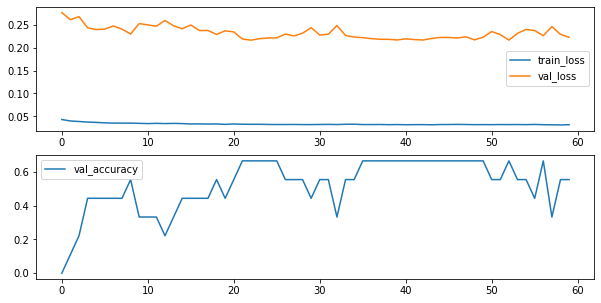

In [ ]:
_, model = train(
  n_epochs=60,
  lr=study.best_params['lr'],
  first_layer_kernel_size=study.best_params['first_layer_kernel_size'],
  dropout_rate=study.best_params['dropout_rate'],
  plot=True,
)

## Show images and their true label-predicted label

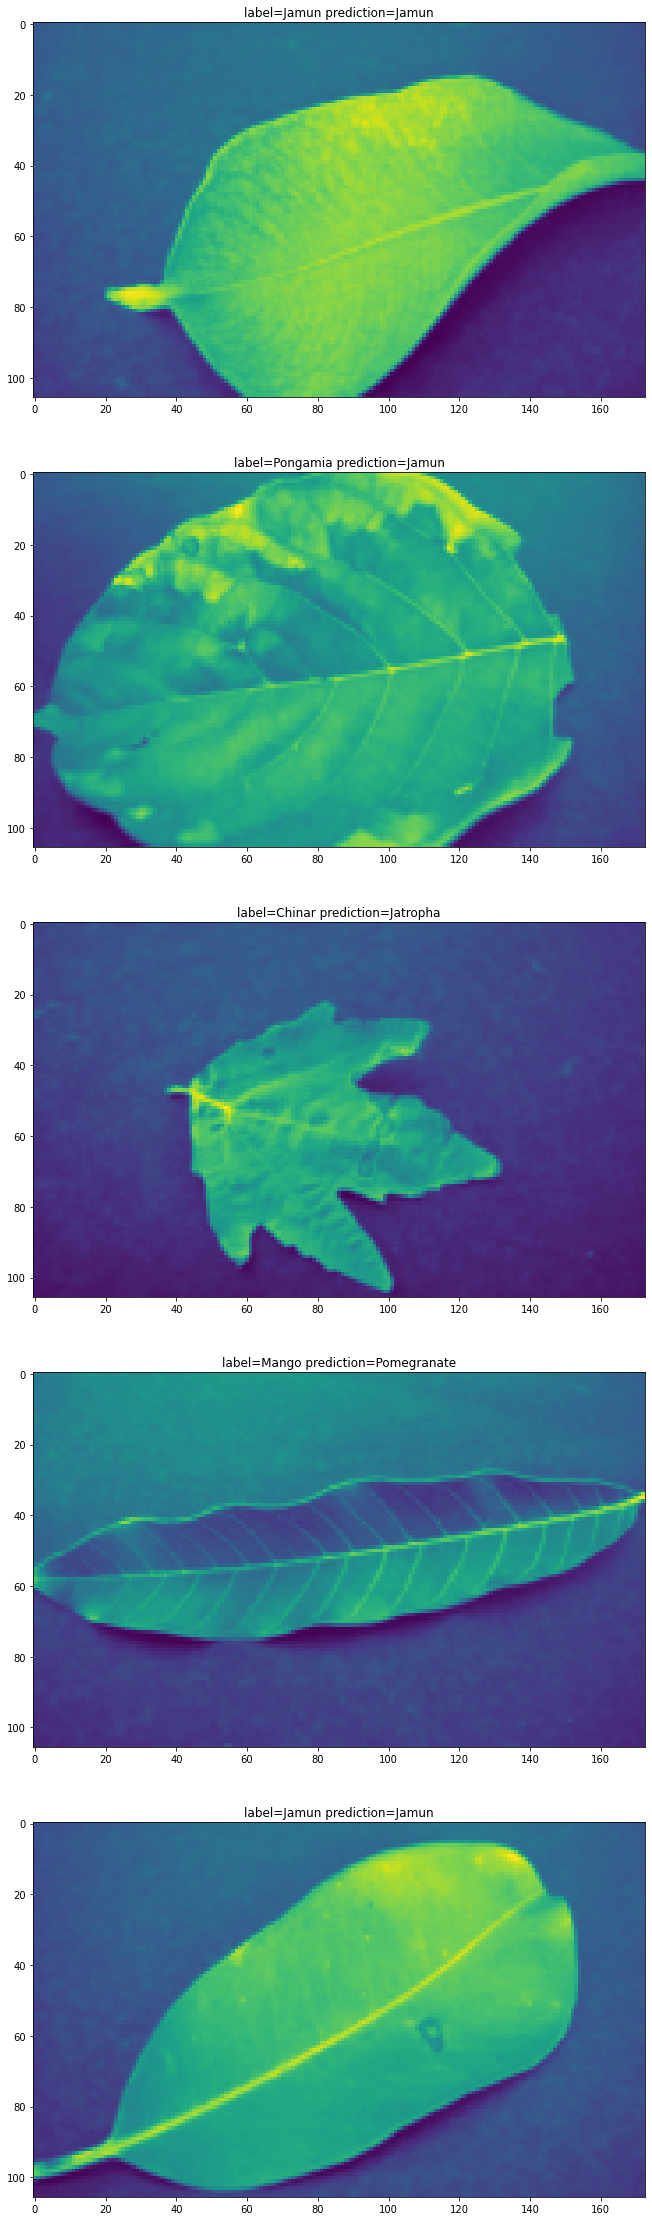

100%|██████████| 1/1 [00:00<00:00, 68.56it/s]

Test loss: 0.1828
Test accuracy: 0.4167


In [ ]:
plt.rcParams['figure.figsize'] = [30,40] # make plots bigger
for (img, label) in dataloaders['test']:
  label = label.to(device)
  batch_size = img.shape[0]
  img = img.to(device)
  img = (img[:, None] / 255).float()
  pred = t.argmax(model(img), dim=1).int()
  fig, axes = plt.subplots(5, 1)
  for i, ax in enumerate(axes):
    cur_pred = pred[i]
    pred_label = unique_labels[cur_pred]
    true_label = unique_labels[label.cpu()[i]]
    ax.imshow(img[i].cpu().permute(1, 2, 0))
    ax.title.set_text(f'label={true_label} prediction={pred_label}')
  plt.show()
  break  

test_loss, test_acc = test_or_valid(
  dataloader=dataloaders['test'],
  model=model) # compute test loss and accuracy

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")